<a href="https://colab.research.google.com/github/OhmaAllen/stick-figure-generator-by-DCGAN/blob/main/ece176_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ECE176 project

### load the dataset(this demo is using airplane as the targeted figure. you can choose whatever you want from the dataset)

In [ ]:
import subprocess
import numpy as np

# Define the GS URI
gs_uri = "gs://quickdraw_dataset/full/numpy_bitmap/airplane.npy"

# Define the local file path to save the .npy file
local_file_path = "airplane.npy"

subprocess.run(["gsutil", "cp", gs_uri, local_file_path], check=True)
airplane_data = np.load(local_file_path)
airplane_data_normalized = (airplane_data.astype(np.float32) - 127.5) / 127.5
# Reshape the data for DCGAN
airplane_data_reshaped = airplane_data_normalized.reshape(-1, 28, 28, 1)

print(airplane_data_reshaped.shape)



(151623, 28, 28, 1)


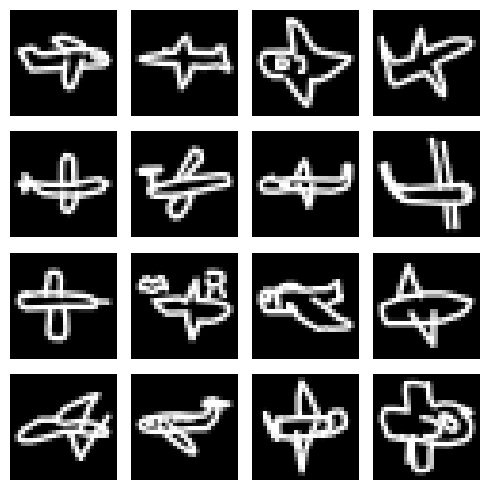

In [ ]:
import matplotlib.pyplot as plt

# Choose 16 random indices from the dataset
indices = np.random.choice(airplane_data_reshaped.shape[0], 16, replace=False)

# Plot images
plt.figure(figsize=(5, 5))  # Smaller figure size
for i in range(16):
    plt.subplot(4, 4, i+1)  # 4x4 grid, position i+1
    img = airplane_data_reshaped[indices[i], :, :, 0]  # Select and reshape image
    plt.imshow(img, cmap='gray')
    plt.axis('off')  # No axis for a cleaner look
plt.tight_layout()
plt.show()



In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset

# Define device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Generator(nn.Module):
    def __init__(self, z_dim=100, img_channels=1):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Starts with a 1x1 image
            nn.ConvTranspose2d(z_dim, 512, 4, 1, 0, bias=False),  # 4x4 image
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # Size: 512 x 4 x 4
            nn.ConvTranspose2d(512, 256, 3, 2, 1, bias=False),  # 7x7 image
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # Size: 256 x 7 x 7
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),  # 14x14 image
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # Size: 128 x 14 x 14
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),  # 28x28 image
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # Size: 64 x 28 x 28
            nn.ConvTranspose2d(64, img_channels, 3, 1, 1, bias=False),  # 28x28 image
            nn.Tanh()
            # Output Size: img_channels x 28 x 28
        )

    def forward(self, input):
        output = self.main(input)
        return output


# Discriminator definition
class Discriminator(nn.Module):
    def __init__(self, img_channels):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(img_channels, 128, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 3, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        output = self.main(input)
        return output.view(-1, 1)

# Assuming airplane_data_reshaped is your input data reshaped correctly
tensor_data = torch.Tensor(airplane_data_reshaped).permute(0, 3, 1, 2)  # Example reshape
dataset = TensorDataset(tensor_data)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

z_dim = 100
img_channels = 1  # Adjust this based on your dataset (1 for grayscale, 3 for RGB)
generator = Generator(z_dim, img_channels).to(device)
discriminator = Discriminator(img_channels).to(device)

# Initialize BCELoss function
criterion = nn.BCELoss()

# Setup Adam optimizers for both G and D
lr = 0.0002
beta1 = 0.5
optimizerD = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))

# Learning rate schedulers
schedulerD = optim.lr_scheduler.StepLR(optimizerD, step_size=1, gamma=0.99)
schedulerG = optim.lr_scheduler.StepLR(optimizerG, step_size=1, gamma=0.99)

real_label = 0.9  # Soft label for real images
fake_label = 0  # Hard label for fake images

num_epochs = 5  # Adjust based on your needs

print("Starting Training Loop...")
# Lists to keep track of progress
G_losses = []
D_losses = []

for epoch in range(num_epochs):
    # Assuming 'dataloader' is defined somewhere with your dataset
    for i, data in enumerate(dataloader, 0):
        # Update D: Maximize log(D(x)) + log(1 - D(G(z)))
        ## Train with all-real batch
        discriminator.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)

        # Forward pass real batch through D
        output = discriminator(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        noise = torch.randn(b_size, z_dim, 1, 1, device=device)
        fake = generator(noise)
        label.fill_(fake_label)
        output = discriminator(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        # Update G: Maximize log(D(G(z)))
        generator.zero_grad()
        label.fill_(real_label)
        output = discriminator(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader), errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())





Starting Training Loop...
[0/5][0/1185]	Loss_D: 1.3525	Loss_G: 1.7265	D(x): 0.4527	D(G(z)): 0.4279 / 0.1567
[0/5][50/1185]	Loss_D: 0.8951	Loss_G: 3.5644	D(x): 0.5250	D(G(z)): 0.0583 / 0.0222
[0/5][100/1185]	Loss_D: 0.5139	Loss_G: 3.4336	D(x): 0.9018	D(G(z)): 0.1163 / 0.0316
[0/5][150/1185]	Loss_D: 0.4287	Loss_G: 3.7005	D(x): 0.8370	D(G(z)): 0.0344 / 0.0200
[0/5][200/1185]	Loss_D: 0.4173	Loss_G: 3.4706	D(x): 0.8357	D(G(z)): 0.0423 / 0.0256
[0/5][250/1185]	Loss_D: 0.9058	Loss_G: 5.1575	D(x): 0.8479	D(G(z)): 0.3874 / 0.0039
[0/5][300/1185]	Loss_D: 0.7034	Loss_G: 2.8410	D(x): 0.6515	D(G(z)): 0.0985 / 0.0501
[0/5][350/1185]	Loss_D: 1.1308	Loss_G: 3.8118	D(x): 0.8344	D(G(z)): 0.4949 / 0.0175
[0/5][400/1185]	Loss_D: 0.5976	Loss_G: 2.1800	D(x): 0.6467	D(G(z)): 0.0554 / 0.1102
[0/5][450/1185]	Loss_D: 0.7147	Loss_G: 2.4182	D(x): 0.8274	D(G(z)): 0.2781 / 0.0804
[0/5][500/1185]	Loss_D: 1.0424	Loss_G: 3.8540	D(x): 0.8871	D(G(z)): 0.4742 / 0.0170
[0/5][550/1185]	Loss_D: 1.4727	Loss_G: 3.5891	D(x): 0

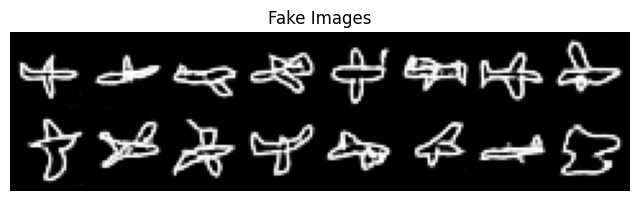

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils

# Number of images to generate
num_images = 16

# Generate random noise as input for the generator
noise = torch.randn(num_images, z_dim, 1, 1, device=device)

# Generate fake images with the generator
with torch.no_grad():  # We don't need to track gradients here
    fake_images = generator(noise).detach().cpu()

# Plot the fake images
fig = plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(fake_images, padding=2, normalize=True), (1, 2, 0)))

# Show the plot
plt.show()


In [ ]:
num_epochs = 50
print("Starting Training Loop...")
# Lists to keep track of progress
G_losses = []
D_losses = []

for epoch in range(num_epochs):
    # Assuming 'dataloader' is defined somewhere with your dataset
    for i, data in enumerate(dataloader, 0):
        # Update D: Maximize log(D(x)) + log(1 - D(G(z)))
        ## Train with all-real batch
        discriminator.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)

        # Forward pass real batch through D
        output = discriminator(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        noise = torch.randn(b_size, z_dim, 1, 1, device=device)
        fake = generator(noise)
        label.fill_(fake_label)
        output = discriminator(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        # Update G: Maximize log(D(G(z)))
        generator.zero_grad()
        label.fill_(real_label)
        output = discriminator(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader), errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())


Starting Training Loop...
[0/50][0/1185]	Loss_D: 0.7376	Loss_G: 3.7754	D(x): 0.9389	D(G(z)): 0.2836 / 0.0186
[0/50][50/1185]	Loss_D: 0.4808	Loss_G: 2.3789	D(x): 0.8088	D(G(z)): 0.0791 / 0.0913
[0/50][100/1185]	Loss_D: 0.6321	Loss_G: 2.5614	D(x): 0.8318	D(G(z)): 0.2029 / 0.0730
[0/50][150/1185]	Loss_D: 0.5871	Loss_G: 2.2516	D(x): 0.6498	D(G(z)): 0.0363 / 0.1035
[0/50][200/1185]	Loss_D: 0.7821	Loss_G: 1.0939	D(x): 0.5275	D(G(z)): 0.0299 / 0.3637
[0/50][250/1185]	Loss_D: 0.5344	Loss_G: 2.3345	D(x): 0.8050	D(G(z)): 0.1305 / 0.0914
[0/50][300/1185]	Loss_D: 0.5325	Loss_G: 3.2681	D(x): 0.8441	D(G(z)): 0.1382 / 0.0333
[0/50][350/1185]	Loss_D: 0.4395	Loss_G: 3.5753	D(x): 0.9274	D(G(z)): 0.0722 / 0.0264
[0/50][400/1185]	Loss_D: 0.6767	Loss_G: 1.8845	D(x): 0.6155	D(G(z)): 0.0635 / 0.1625
[0/50][450/1185]	Loss_D: 0.5532	Loss_G: 2.2614	D(x): 0.7214	D(G(z)): 0.0729 / 0.1002
[0/50][500/1185]	Loss_D: 0.5043	Loss_G: 2.3355	D(x): 0.7823	D(G(z)): 0.0854 / 0.0893
[0/50][550/1185]	Loss_D: 0.5776	Loss_G: 2.

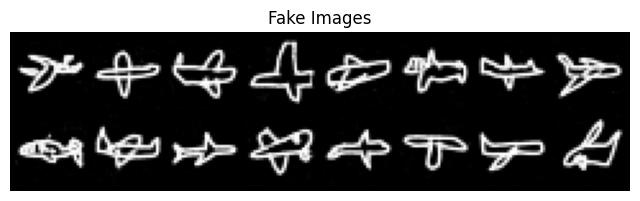

In [ ]:
# Number of images to generate
num_images = 16

# Generate random noise as input for the generator
noise = torch.randn(num_images, z_dim, 1, 1, device=device)

# Generate fake images with the generator
with torch.no_grad():  # We don't need to track gradients here
    fake_images = generator(noise).detach().cpu()

# Plot the fake images
fig = plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(fake_images, padding=2, normalize=True), (1, 2, 0)))

# Show the plot
plt.show()